In [87]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.rcParams['image.cmap'] = 'gist_earth'

In [101]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util

import glob
from scripts.radio_util import DataProvider

In [89]:
from helper_functions import *

In [90]:
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return numpy.asarray(imgs)

In [91]:

data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'

# Extract it into numpy arrays.
IMG_PATCH_SIZE = 400
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_data(train_labels_filename, TRAINING_SIZE)

Loading training/images/satImage_001.png
Loading training/images/satImage_002.png
Loading training/images/satImage_003.png
Loading training/images/satImage_004.png
Loading training/images/satImage_005.png
Loading training/images/satImage_006.png
Loading training/images/satImage_007.png
Loading training/images/satImage_008.png
Loading training/images/satImage_009.png
Loading training/images/satImage_010.png
Loading training/groundtruth/satImage_001.png
Loading training/groundtruth/satImage_002.png
Loading training/groundtruth/satImage_003.png
Loading training/groundtruth/satImage_004.png
Loading training/groundtruth/satImage_005.png
Loading training/groundtruth/satImage_006.png
Loading training/groundtruth/satImage_007.png
Loading training/groundtruth/satImage_008.png
Loading training/groundtruth/satImage_009.png
Loading training/groundtruth/satImage_010.png


(572, 572)
(1, 572, 572, 2)
(572, 572)


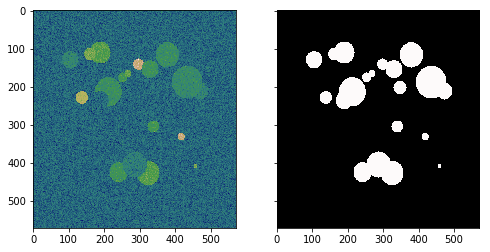

In [109]:
nx = 572
ny = 572
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=20)
generator2 = image_gen.RgbDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(1)
x_test.shape
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto" )
ax[1].imshow(y_test[0,...,1], aspect="auto")
print(x_test[0,...,0].shape)
print(y_test.shape)
print(y_test[0,...,1].shape)

In [93]:
x_test = train_data[0]
y_test = train_labels[0]
x_test.shape
#x_test = x_test.reshape([20,20,3])
#x_test.shape
y_test.shape

(400, 400)

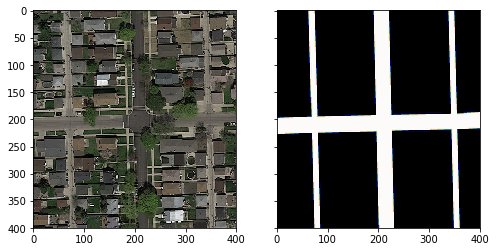

In [94]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test, aspect="auto" )
ax[1].imshow(y_test, aspect="auto")

In [95]:
net = unet.Unet(channels=3, n_class=2, layers=3, features_root=16)

2017-11-29 16:41:36,342 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [96]:
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

In [105]:


files = glob.glob(train_data_filename+'*')

data_provider = DataProvider(600, files)
data_provider(1)

Number of files used: 100


OSError: Unable to open file (file signature not found)

In [97]:
path = trainer.train([x_test,y_test], "./unet_trained", training_iters=1, epochs=1, display_step=2)

2017-11-29 16:41:39,360 Removing '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/prediction'
2017-11-29 16:41:39,361 Removing '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet_trained'
2017-11-29 16:41:39,363 Allocating '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/prediction'
2017-11-29 16:41:39,368 Allocating '/home/zampieri/Documents/EPFL/ML/LMO_ML/project2/project_Luca/unet_trained'


TypeError: 'list' object is not callable

In [26]:
x_test, y_test = generator(1)

prediction = net.predict("unet_trained/model.cpkt", x_test)

INFO:tensorflow:Restoring parameters from unet_trained/model.cpkt


2017-11-29 16:20:56,778 Restoring parameters from unet_trained/model.cpkt
2017-11-29 16:20:56,907 Model restored from file: unet_trained/model.cpkt


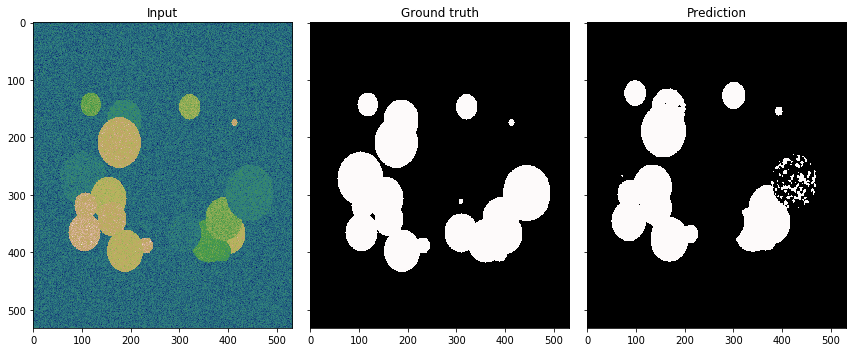

In [27]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
mask = prediction[0,...,1] > 0.07
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
fig.tight_layout()
#£fig.savefig("../docs/toy_problem.png")